<h1><b>Estimate Real Estate Prices Based on their Characteristics</b></h1>
<h2>Antonio Dottori</h2>

The objective here is to build a regressor that will predict the prices of real estate properties.

Importing the libraries we'll need:

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from scipy.stats import pearsonr, norm, skew
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


Initially, let's read the files containg the data. Here, we have two switches: <br>

training --> if True, it will run for the train set, and if False, it will run for the test set. To use, you set it first as True and goes to Run All. After that, set it to False and Run All again.<br>
finding_best_parameters --> if True, it will run the steps in which we determine the best fits for each model we used. If false, it will run with the values already determined (which were gotten after running this as True.)

In [2]:
re_training = pd.read_csv("../files/lesson_2/conjunto_de_treinamento.csv", sep=",")
re_testing = pd.read_csv("../files/lesson_2/conjunto_de_teste.csv", sep=",")

training = True
finding_best_parameters = False

if training:
    re = re_training
else:
    re = re_testing

For a quick check if it's loaded, let's call the DataFrame's head().

In [3]:
re.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


<p>We can also see the transposed DataFrame to take a look at the columns.</p>

In [4]:
re.T

,0,1,2,3,4,5,6,7,8,9,...,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682
Id,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,6673,6674,6675,6676,6677,6678,6679,6680,6681,6682
tipo,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,...,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento
bairro,Imbiribeira,Casa Amarela,Encruzilhada,Boa Viagem,Rosarinho,Boa Vista,Rosarinho,Espinheiro,Boa Viagem,Boa Viagem,...,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Torre,Boa Viagem,Setubal,Torre,Casa Amarela,Madalena
tipo_vendedor,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,...,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria
quartos,3,4,3,4,2,3,4,3,4,3,...,5,4,4,4,3,4,2,3,3,3
suites,3,4,1,3,1,0,2,1,4,1,...,2,2,4,2,1,4,0,1,2,1
vagas,5,2,0,2,1,1,0,1,3,1,...,2,3,2,0,2,3,1,1,3,2
area_util,223,157,53,149,54,130,105,124,170,72,...,367,231,137,170,63,170,82,75,136,84
area_extra,167,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
diferenciais,piscina e copa,piscina e churrasqueira,nenhum,piscina e churrasqueira,piscina e churrasqueira,playground,piscina e playground,nenhum,piscina e churrasqueira,nenhum,...,frente para o mar e salao de festas,salao de festas,piscina e playground,piscina e churrasqueira,piscina e churrasqueira,piscina e churrasqueira,churrasqueira,nenhum,piscina e copa,piscina e playground


<h2><b>Data Describing</b></h2> <br>
Let's look at some information on our data: count, mean and standart deviation.

In [5]:
re.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4683.0,4341.000000,1.352010e+03,2000.0,3170.5,4341.0,5511.5,6682.0
quartos,4683.0,3.043562,8.735901e-01,1.0,3.0,3.0,4.0,9.0
suites,4683.0,1.434337,1.102457e+00,0.0,1.0,1.0,2.0,6.0
vagas,4683.0,1.708093,1.210975e+00,0.0,1.0,2.0,2.0,30.0
area_util,4683.0,124.158018,1.073651e+02,21.0,68.0,96.0,149.0,2045.0
area_extra,4683.0,13.293188,2.668038e+02,0.0,0.0,0.0,0.0,17450.0
churrasqueira,4683.0,0.316891,4.653142e-01,0.0,0.0,0.0,1.0,1.0
estacionamento,4683.0,0.030750,1.726567e-01,0.0,0.0,0.0,0.0,1.0
piscina,4683.0,0.555627,4.969491e-01,0.0,0.0,1.0,1.0,1.0
playground,4683.0,0.157378,3.641954e-01,0.0,0.0,0.0,0.0,1.0


Let's see the correlation matrix to try and extract some useful information.

In [6]:
re_correlation = re.corr(method='pearson')
re_correlation.style.background_gradient(cmap='coolwarm')

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
Id,1.000000,0.029451,0.015379,0.009520,0.013224,0.018732,0.008258,-0.002840,0.001808,-0.009614,-0.004397,-0.000958,0.014551,-0.000201,-0.016590,0.007085,-0.009643
quartos,0.029451,1.000000,0.615051,0.475978,0.533707,0.036177,0.025407,-0.007467,-0.006567,-0.020210,0.032836,-0.046180,0.019603,-0.047982,0.016866,0.101089,0.020892
suites,0.015379,0.615051,1.000000,0.489184,0.462092,0.019077,0.128838,-0.034273,0.168748,-0.042081,0.030506,-0.081970,-0.016222,-0.013010,0.128119,0.103842,0.042131
vagas,0.009520,0.475978,0.489184,1.000000,0.506815,0.054553,0.078155,-0.017331,0.064786,-0.048363,0.008572,-0.085419,-0.018537,-0.009597,0.054788,0.066371,0.029046
area_util,0.013224,0.533707,0.462092,0.506815,1.000000,0.038041,-0.008369,-0.002981,-0.050387,-0.062704,0.016866,-0.030103,-0.010287,-0.009904,0.026200,0.105070,0.027557
area_extra,0.018732,0.036177,0.019077,0.054553,0.038041,1.000000,-0.011806,-0.005709,0.005509,-0.015286,0.066076,-0.011844,-0.004017,-0.005824,-0.008840,0.001416,0.001141
churrasqueira,0.008258,0.025407,0.128838,0.078155,-0.008369,-0.011806,1.000000,-0.110680,0.476099,-0.267884,-0.113665,-0.254080,-0.056495,-0.072266,-0.186562,-0.097286,0.015878
estacionamento,-0.002840,-0.007467,-0.034273,-0.017331,-0.002981,-0.005709,-0.110680,1.000000,-0.079682,0.011337,-0.023153,-0.010377,-0.014774,0.000341,-0.058146,-0.029858,-0.006367
piscina,0.001808,-0.006567,0.168748,0.064786,-0.050387,0.005509,0.476099,-0.079682,1.000000,-0.084374,-0.023684,-0.273352,-0.077101,-0.053893,0.144815,-0.066208,0.006809
playground,-0.009614,-0.020210,-0.042081,-0.048363,-0.062704,-0.015286,-0.267884,0.011337,-0.084374,1.000000,0.061126,0.112458,-0.021611,0.055193,-0.081451,-0.043675,-0.012199


Let's see the price distribution too.

C:\Users\dotto\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


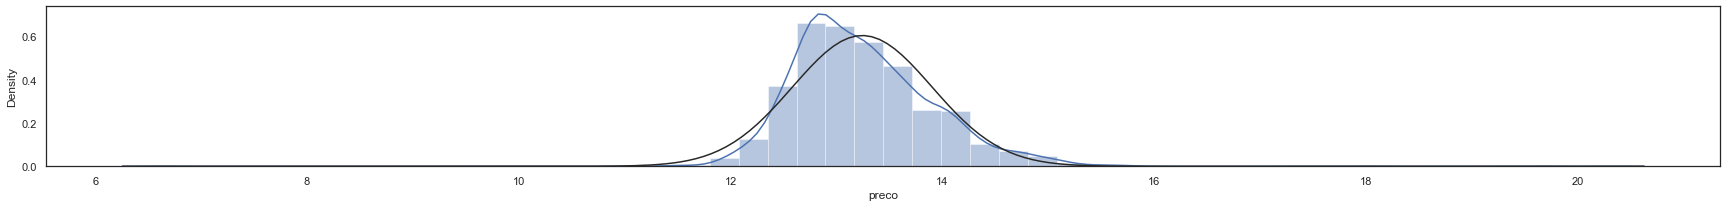

In [7]:
if training:
    import seaborn as sns
    from matplotlib.gridspec import GridSpec

    sns.set_style("white")
    fig = plt.figure(figsize=(30,10))
    gs = GridSpec(3,2)

    sns.distplot(re["preco"].apply(lambda x: math.log(x)), fit=norm, ax=fig.add_subplot(gs[1,:]))


<h2><b>Data Cleaning</b></h2>

In this DataFrame there are columns that are not so useful for our analysis. For this reason, let's remove them.

They are:<br>
id --> just an index value <br>
diferenciais --> this column is already explicited on the columns to the side.

In [8]:
columns_to_remove = [
    "Id",
    "diferenciais",
]

columns_to_keep = [column for column in re.columns if column not in columns_to_remove]
re = re[columns_to_keep]

Now, we'll split the columns into their types. They can be categorical variables, i.e., those that, even though they may be numbers, they are mentions to a category of some kind, or numerical variables. <br>

<h2><b>Categorical Variables</b></h2>

<br>Filtering the "object type" columns gives us a first filter for this classification, but we can also select manually some other columns that we find suitable. Another concept we should have in mind is that the categorical variables may be nominal (i.e., they are in no way related in an order of magnitude, they just represent a category) or ordinal (i.e., they have an order of importance inherited.).


In [9]:
re.columns[re.dtypes==object]

Index(['tipo', 'bairro', 'tipo_vendedor'], dtype='object')

<h3><b>Nominal Variables</b></h3><br>As stated, we will use the filtered columns from the previous step, and may add some more that fit into this category. In this case, there are no more columns that fit in this classification.

In [10]:
nominal_categorical_columns = [
    'tipo', 
    'bairro', 
    'tipo_vendedor',
]

Let's look at the cardinality, and we may drop the columns that have a great variety, because, as categorical values, they will have a lot of noise attached to them.

In [11]:
re[nominal_categorical_columns].nunique().sort_values(ascending=False)

bairro           66
tipo              4
tipo_vendedor     2
dtype: int64

In this case, we'll keep all of the columns, because "tipo" and "tipo_vendedor" are columns with low cardinality, and "bairro" has a great variety of values, but it is an important metric to consider, because, for example, a 3 bedroom house in a fancy neighborhood will certainly cost more than the same house at a less fancy one.

<h3><b>One Hot Encoding</b></h3><br>
We can perform an ONE-HOT encoding in these three columns. For this, we'll use the One Hot Encoder sklearn's native function. We encode the column, append the array we got to the original DataFrame, and drop the original column.

In [12]:
if training:
    one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown="ignore")
    one_hot_encoder.fit(re[nominal_categorical_columns])
one_hot_encoded_columns = one_hot_encoder.transform(re[nominal_categorical_columns]).toarray()

In [13]:
ohe_df = pd.DataFrame(one_hot_encoded_columns, columns=one_hot_encoder.get_feature_names())

re = pd.concat([re, ohe_df], axis=1).drop(nominal_categorical_columns, axis=1)

<h3><b>Binary Columns</b></h3><br>
Let's give a check for binary columns, i.e., those that are categorical only with True or False values.

In [14]:
columns_unique_values = [{column: re[column].unique()} for column in re.columns]
columns_unique_values

[{'quartos': array([3, 4, 2, 1, 5, 6, 7, 8, 9], dtype=int64)},
 {'suites': array([3, 4, 1, 0, 2, 5, 6], dtype=int64)},
 {'vagas': array([ 5,  2,  0,  1,  3,  4,  6,  8, 10,  7, 20, 18, 12, 17, 13, 15, 30],
        dtype=int64)},
 {'area_util': array([ 223,  157,   53,  149,   54,  130,  105,  124,  170,   72,  125,
          150,   92,  120,  500,   75,  104,  135,   82,  198,   67,  145,
          163,  100,  209,  247,   65,   88,   50,  109,   80,   97,   57,
           93,  310,  159,   96,   55,   89,   60,  161,   66,  113,  133,
           64,   70,   56,  177,   38,  204,  110,   52,  237,   63,  137,
           95,   78,  140,  200,  205,   90,  132,   68,  127,  119,  165,
          203,  128,  101,   86,   43,   46,  289,  263,  285,  102, 1304,
          220,   61,   79,  400,   77,   47,  213,  107,  139,   76,  274,
           73,  370,  155,  230,  210,  173,   59,  265,  186,   58,  255,
           85,  106,  114,  295,  312,  193,  152,  160,  147,  166,   48,
        

As we can see, the following columns have just 1 and 0 values. They are all the columns that were one hot encoded, and the ones that represent the features from the property.

In [15]:
binary_categorical_columns = list(one_hot_encoder.get_feature_names()) + [
    'churrasqueira', 
    'estacionamento', 
    'piscina',
    'playground', 
    'quadra', 
    's_festas', 
    's_jogos', 
    's_ginastica', 
    'sauna',
    'vista_mar',
]

<h2><b>Numerical Columns</b></h2>

All the other columns that were not mentioned yet are numerical columns.

In [16]:
numerical_columns = [x for x in re.columns if x not in nominal_categorical_columns + binary_categorical_columns]
numerical_columns

['quartos', 'suites', 'vagas', 'area_util', 'area_extra', 'preco']

<h2><b>NaN values</b></h2><br>Now, let's check if there are any NaN values in our columns.

In [17]:
re.isna().any().sum()

0

Not even a single NaN in our DataFrame, which is great!

<h1><b>Training</b></h1><br>
Let's go the training! First, we define a function to calculate the root mean squared percentage error.

In [18]:
def root_mean_squared_percentage(y, y_answer):
    return np.sqrt(np.mean(np.square(((y-y_answer)/y)), axis=0))

If we're training our model, we need to shuffle the DataFrame.

In [19]:
if training:
    shuffled_re = re.sample(frac=1, random_state=12345)

In [20]:
if training:
    x = shuffled_re.iloc[:, shuffled_re.columns!='preco']
    y = shuffled_re.iloc[:, shuffled_re.columns=='preco']

else:
    x = re.iloc[:, re.columns!='preco']

<p>And now, if we're training, we'll divide the DataFrame in a training and a test set. We need to divide into two reasonable sizes, so there is a training set big enough so that the Machine will be able to be  well trained. Also, we need a good test set size so we can see clearly if it's working fine on the predictions. A good ratio should be training:test as 80:20.</p>

In [21]:
if training:
    num_lines = shuffled_re.shape[0]
    training_size = round(0.8*num_lines)

In [22]:
if training:
    x_training = x.values[:training_size,:-1]
    y_training = y.values[:training_size,-1].ravel()

    x_test = x.values[training_size:,:-1]
    y_test = y.values[training_size:,-1].ravel()

else:
    x_test = x.values[:, :-1]

Let's begin the training for different regressors. For each one of them, we'll train the set for various input parameters to see which one will give us the smallest error.

<h1><b>Gradient Boosting<b></h1>

Let's try the gradient boost first. After running, I kept it commented to prevent from running another time, because it took approximately 45 minutes.

In [23]:
if training and finding_best_parameters:
    results = []
    for i in range(2, 36, 2):
        for j in range(10, 150, 10):
            for k in ['least_squares', 'least_absolute_deviation']:
                for l in range(10, 16, 1):
                    rgsGB = HistGradientBoostingRegressor(l2_regularization=i, max_iter=j, loss=k, max_depth=l)
                    print (i, j, k, l)
                    rgsGB = rgsGB.fit(x_training, y_training)

                    y_train_answer = rgsGB.predict(x_training)
                    y_test_answer = rgsGB.predict(x_test)

                    rmspe_in = root_mean_squared_percentage(y_training, y_train_answer)
                    rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)
                    results.append((l, k, j, i, rmspe_in, rmspe_out))

    best_parameters = sorted(results, key=lambda i: i[-1], reverse=True)[-1]

Running again for these parameters we got:

In [24]:
if training:
    rgsGB = HistGradientBoostingRegressor(l2_regularization=32, max_iter=100, loss='least_absolute_deviation', max_depth=12)

    rgsGB = rgsGB.fit(x_training, y_training)

    y_train_answer = rgsGB.predict(x_training)
    y_test_answer = rgsGB.predict(x_test)

    rmspe_in = root_mean_squared_percentage(y_training, y_train_answer)
    rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)
    print(f'rmspe_in {rmspe_in}, rmspe_out {rmspe_out}')

else:
    y_test_answer_gb = rgsGB.predict(x_test)

rmspe_in 4.7040658983656805, rmspe_out 0.23906906540213935


Let's calculate the R^2 for this method.

In [25]:
r2_out = r2_score(y_test,y_test_answer)
r2_out

0.03842217920674329

<h1><b>KNN</b></h1>

In [26]:
if training and finding_best_parameters:
    results = []
    for k in range(1,50,1):
        for p in range (1,3):
            print (k, p)
            rgsKNN = KNeighborsRegressor(n_neighbors=k, p=p, n_jobs=2, algorithm='kd_tree', weights='distance')
            
            rgsKNN = rgsKNN.fit(x_training, y_training)

            y_train_answer = rgsKNN.predict(x_training)
            y_test_answer = rgsKNN.predict(x_test)
                
            rmspe_in = root_mean_squared_percentage(y_training, y_train_answer)
            rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)

            print(f'K {k}, rmspe_in {rmspe_in}, rmspe_out {rmspe_out}')
            results.append((k, p, rmspe_in, rmspe_out))

    best_parameters = sorted(results, key=lambda i: i[-1], reverse=True)[-1]
    best_parameters


See that we got the best results for k=5 neighbors.

In [27]:
if training:
    rgsKNN = KNeighborsRegressor(n_neighbors=5, p=1, n_jobs=2, algorithm='kd_tree', weights='distance')

    rgsKNN = rgsKNN.fit(x_training, y_training)

    y_train_answer = rgsKNN.predict(x_training)
    y_test_answer = rgsKNN.predict(x_test)
        
    rmspe_in = root_mean_squared_percentage(y_training, y_train_answer)
    rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)

    print(f'K {5}, rmspe_in {rmspe_in}, rmspe_out {rmspe_out}')

else:
    y_test_answer_knn = rgsKNN.predict(x_test)

K 5, rmspe_in 0.05137546972026827, rmspe_out 0.3687271338901099


The error we got is a lot greater than the Gradient Boosting: 0.3687271338901099/0.23906906540213935 - 1 = 54.2%.

<h1><b>Polynomial Regressor</b></h1>

In [28]:
if training and finding_best_parameters:
    results = []
    for k in range(1,3):
        pf = PolynomialFeatures(degree=k)    
        pf = pf.fit(x_training)
        x_polynomial_training = pf.transform(x_training)
        x_polynomial_test = pf.transform(x_test)
        
        rgsL = LinearRegression()
        rgsL = rgsL.fit(x_polynomial_training, y_training)

        y_training_answer = rgsL.predict(x_polynomial_training)
        y_test_answer = rgsL.predict(x_polynomial_test)
        
        rmspe_in = root_mean_squared_percentage(y_training, y_training_answer)
        rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)
        
        n_atributos = x_polynomial_training.shape[1]    

        print(f'K {k} rmspe_in {rmspe_in}, rmspe_out {rmspe_out}')
        results.append([k, rmspe_in, rmspe_out])
    
    best_parameters = sorted(results, key=lambda i: i[-1], reverse=True)[-1]
    best_parameters
        

We can see that the error in this model is a lot worse too. Running for k=3 made my computer explode twice, so I just left it out of the analysis.

<h1><b>Random Forest</b></h1>

In [29]:
results = []
if training and finding_best_parameters:
    for i in range(100, 2000, 100):
        rgsRF = RandomForestRegressor(n_estimators=i,random_state=0,min_samples_leaf=2,n_jobs=10,criterion='mse',verbose=0)
        rgsRF = rgsRF.fit(x_training, y_training)

        y_train_answer = rgsRF.predict(x_training)
        y_test_answer = rgsRF.predict(x_test)

        rmspe_in = root_mean_squared_percentage(y_training, y_train_answer)
        rmspe_out = root_mean_squared_percentage(y_test, y_test_answer)
        
        print(f'n_estimators {i}, rmspe_in {rmspe_in}, rmspe_out {rmspe_out}')
        results.append([i, rmspe_in, rmspe_out])
    
    best_parameters = sorted(results, key=lambda i: i[-1], reverse=True)


The error we got here is a lot greater too, around 14.

<h2><b>Cross Validation</b></h2><br>

Finally, let's perform the Cross Validation for the best performing model, which was Gradient Booster.

In [30]:
if training:
    scores = cross_val_score(
        rgsGB,
        x.values,
        y.values.ravel(),
        cv=8,
    )

    print (
        'scores =',scores,
        'acurácia média = %6.1f' % (100*sum(scores)/8)
        )

scores = [ 0.84657739  0.83880935  0.82438231 -0.00191965 -0.00154954  0.79689099
  0.02257559  0.86213502] acurácia média =   52.3


<h2>Exporting the Results</h2><br>
We got the best result from the Gradient Booster Regressor, so that's the one we will export.
And with this function we will export our test answers in the kaggle format.

In [31]:
if not training:
    pd.DataFrame(
    {
        'Id': np.arange(0, 2000),
        'preco': y_test_answer_gb,
    }
).to_csv('../lesson_2/teste_kaggle.csv', index=False)